In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import itertools

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve
from tqdm import tqdm
import xgboost as xgb #BDT
import pickle
import mplhep as hep

import concurrent.futures as futures

from utils.analysis import Optimization, PandasAnalysis

/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
babies = glob.glob("../analysis/studies/vbsvvhjets/output/Run2/*.root")
babies = [baby for baby in babies if "data" not in baby]
babies

['../analysis/studies/vbsvvhjets/output/Run2/QCD.root',
 '../analysis/studies/vbsvvhjets/output/Run2/TTH.root',
 '../analysis/studies/vbsvvhjets/output/Run2/TTW.root',
 '../analysis/studies/vbsvvhjets/output/Run2/TT1L.root',
 '../analysis/studies/vbsvvhjets/output/Run2/Bosons.root',
 '../analysis/studies/vbsvvhjets/output/Run2/TTHad.root',
 '../analysis/studies/vbsvvhjets/output/Run2/SingleTop.root',
 '../analysis/studies/vbsvvhjets/output/Run2/VBSVVH.root']

In [3]:
vbsvvh = Optimization(
    sig_root_files=babies[-1:],
    bkg_root_files=babies[:-1],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", 
        "pu_sf",
        "prefire_sf"
    ]
)

vbsvvh.df["bdt_presel"] = vbsvvh.df.eval(
    "ST > 1300"
    + "and hbbfatjet_score > 0.5"
    + "and ld_vqqfatjet_score > 0.5 and tr_vqqfatjet_score > 0.5"
    + "and ld_vqqfatjet_mass < 120 and tr_vqqfatjet_mass < 120"
    + "and hbbfatjet_mass < 150"
)

with open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt_features.txt", "r") as txt_file:
    features = txt_file.read().splitlines()
bst = pickle.load(open("../analysis/studies/vbsvvhjets/vbsvvhjets_bdt/bdt.pkl", "rb"))
vbsvvh.df["bdt"] = bst.predict(xgb.DMatrix(vbsvvh.df[features]))

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:06<00:00,  1.02it/s]
/home/users/jguiang/apps/miniconda3/envs/analysis/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [4]:
from utils.cutflow import CutflowCollection, Cutflow, Cut

cutflows = CutflowCollection(
    cutflows={name: Cutflow() for name in vbsvvh.df.name.unique()}
)

In [5]:
def update_cutflows(selection, cut_name=None):
    global vbsvvh
    global cutflows
    selection_str = PandasAnalysis.get_selection_str(selection)
    for name, cutflow in cutflows.items():
        # Get previous cut
        if len(cutflow) > 0:
            prev_cut = cutflow[cutflow.terminal_cut_names[-1]]
        else:
            prev_cut = Cut("Dummy")
        # Create new cut
        _df = vbsvvh.df[(vbsvvh.df.name == name)]
        n_pass_raw = len(_df)
        n_pass_wgt = _df.event_weight.sum()
        new_cut = Cut(
            cut_name or selection_str,
            n_pass=n_pass_raw,
            n_pass_weighted=n_pass_wgt,
            n_fail=(prev_cut.n_pass - n_pass_raw),
            n_fail_weighted=(prev_cut.n_pass_weighted - n_pass_wgt),
        )
        # Insert new cut
        if len(cutflow) > 0:
            cutflow.insert(prev_cut.name, new_cut)
        else:
            cutflow.set_root_cut(new_cut)
            
    if "TotalBkg" in cutflows.names:
        cutflows.pop("TotalBkg")

    cutflows["TotalBkg"] = cutflows.sum()

    for name in vbsvvh.df[vbsvvh.df.is_data | vbsvvh.df.is_signal].name.unique():
        cutflows["TotalBkg"] -= cutflows[name]

In [6]:
vbsvvh.make_selection("bdt_presel")
update_cutflows("bdt_presel")

<AxesSubplot:ylabel='Events'>

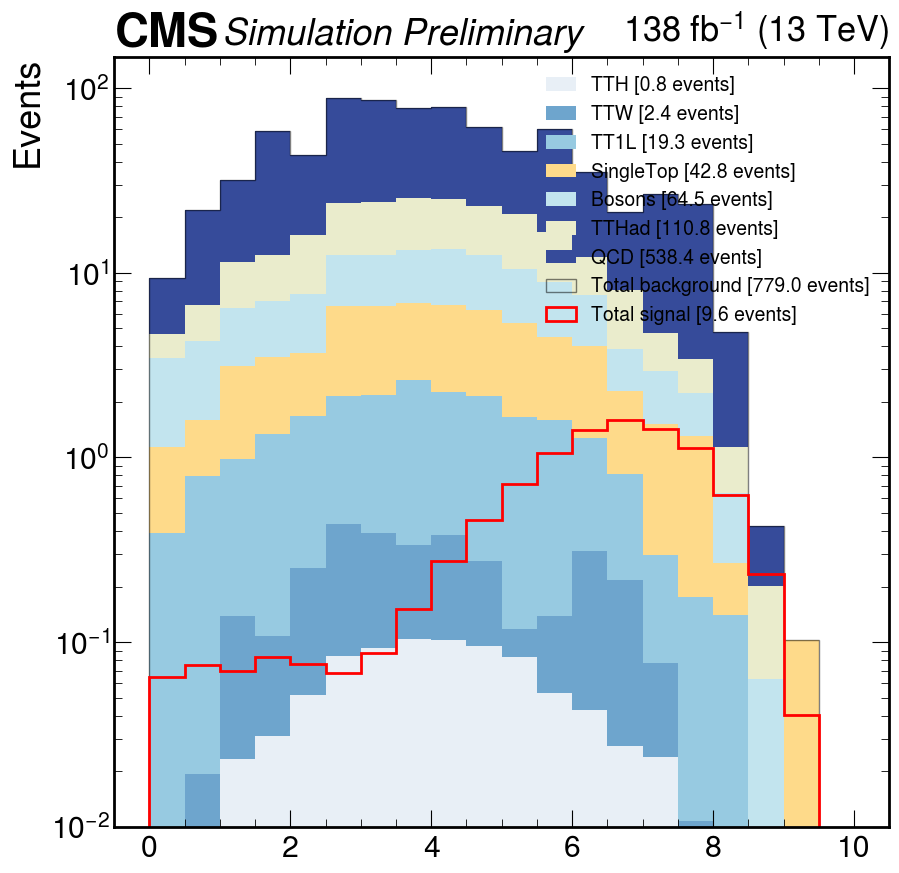

In [7]:
vbsvvh.plot_sig_vs_bkg("deta_jj", np.linspace(0, 10, 21), transf=abs, stacked=True, logy=True)

<AxesSubplot:ylabel='Events'>

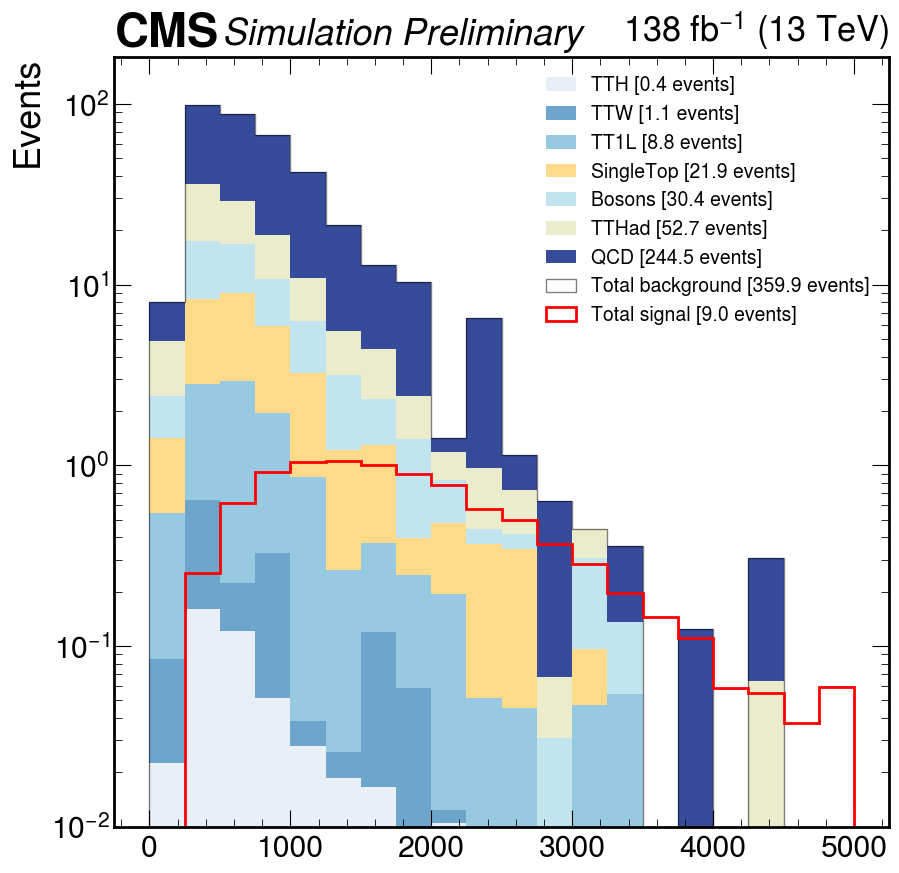

In [8]:
vbsvvh.plot_sig_vs_bkg("M_jj", np.linspace(0, 5000, 21), selection="abs(deta_jj) > 4", stacked=True, logy=True)

In [9]:
vbsvvh.get_event_counts("M_jj > 600 and abs(deta_jj) > 4")

(8.480163939506841, 207.6242298803482)

In [10]:
vbsvvh.get_event_counts("M_jj > 700 and abs(deta_jj) > 4")

(8.230034994871437, 179.47247183177524)

In [11]:
vbsvvh.get_event_counts("M_jj > 800 and abs(deta_jj) > 4")

(7.887956853686112, 156.51428673659586)

In [12]:
vbsvvh.make_selection("M_jj > 700 and abs(deta_jj) > 4")
update_cutflows("M_jj > 700 and abs(deta_jj) > 4")

In [13]:
vbsvvh.get_event_counts()

(8.230034994871437, 179.47247183177524)

In [14]:
np.linspace(0.75, 0.95, 11)

array([0.75, 0.77, 0.79, 0.81, 0.83, 0.85, 0.87, 0.89, 0.91, 0.93, 0.95])

In [15]:
scans = {
    "bdt": np.linspace(0.75, 0.95, 11),
    "hbbfatjet_score": np.linspace(0.5, 0.9, 11),
    "ld_vqqfatjet_score": np.linspace(0.5, 0.9, 11),
    "tr_vqqfatjet_score": np.linspace(0.5, 0.9, 11)
}

cuts = {}
for var, wps in scans.items():
    cuts[var] = []
    for wp in wps:
        cuts[var].append(f"{var} > {wp}")

selections = [" and ".join(combo) for combo in itertools.product(*cuts.values())]

fom = lambda S, B: S/np.sqrt(B) if B > 0 else S/np.sqrt(0.0001)
            
results = []
for sel in tqdm(selections):
    sig, bkg = vbsvvh.get_event_counts(selection=sel)
    results.append((sel, sig, bkg, fom(sig, bkg)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14641/14641 [04:57<00:00, 49.22it/s]


In [16]:
results_df = pd.DataFrame(
    {
        "selection": [r[0] for r in results],
        "sig": [r[1] for r in results],
        "bkg": [r[2] for r in results],
        "fom": [r[3] for r in results]
    }
)

In [17]:
results_df[(results_df.sig > 4.5) & (results_df.bkg > 0)].sort_values("fom", ascending=False)[:15]

,selection,sig,bkg,fom
1302,bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vq...,4.559783,0.886821,4.842016
2642,bdt > 0.77 and hbbfatjet_score > 0.9 and ld_vq...,4.574319,1.039769,4.485988
2512,bdt > 0.77 and hbbfatjet_score > 0.86 and ld_v...,4.529417,1.020641,4.483383
1171,bdt > 0.75 and hbbfatjet_score > 0.86 and ld_v...,4.518443,1.030344,4.451411
2402,bdt > 0.77 and hbbfatjet_score > 0.82000000000...,4.523355,1.035089,4.446024
2631,bdt > 0.77 and hbbfatjet_score > 0.9 and ld_vq...,4.672014,1.109267,4.435945
1192,bdt > 0.75 and hbbfatjet_score > 0.86 and ld_v...,4.591757,1.075329,4.428006
2632,bdt > 0.77 and hbbfatjet_score > 0.9 and ld_vq...,4.551988,1.064360,4.412217
2391,bdt > 0.77 and hbbfatjet_score > 0.82000000000...,4.612787,1.104587,4.388978
1311,bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vq...,4.725625,1.165829,4.376651


In [18]:
bf_SR = results_df[(results_df.sig > 4.5) & (results_df.bkg > 0)].sort_values("fom", ascending=False)[:15].selection.values[0]
bf_SR

'bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.8200000000000001 and tr_vqqfatjet_score > 0.66'

In [26]:
bf_rounded_SR = "bdt > 0.75 and hbbfatjet_score > 0.9 and ld_vqqfatjet_score > 0.80 and tr_vqqfatjet_score > 0.65"
vbsvvh.get_event_counts(bf_rounded_SR)

(4.617725171041109, 0.8891196143541019)

In [20]:
# vbsvvh.df["SR"] = vbsvvh.df.eval(bf_rounded_SR)

# vbsvvh.make_selection("SR")
# update_cutflows("SR")

# cutflows.reorder(["QCD", "TTHad", "TT1L", "TTW", "TTH", "SingleTop", "Bosons", "TotalBkg", "VBSVVH"])
# cutflows.write_csv("test.csv", cutflows.terminal_cut_names[-1])